In [1]:
import pandas as pd
import networkx as nx
import warnings
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
pd.options.mode.chained_assignment = None

In [2]:
green = "#5ec962"
blue_gray = "#3b528b"
purple = "#440154"
colours = [green, purple]

In [3]:
df = pd.read_excel("../data/sociogram_corrected.xlsx").dropna()
df["classroom"] = df["classroom"].astype(int)
periods = pd.read_excel("../data/classroom_ids.xlsx").rename(columns = {"classroom_session_id":"classroom"})[["classroom", "period"]]
tt = periods.merge(df)
tt["classroom"] = tt["classroom"].astype("int")
tt["course"] = tt["period"] - 4

tt["question"] = tt["question"].astype('category').cat.rename_categories({
    "work_yes": "Working with",
    "work_no": "Not working with",
    "play_yes": "Playing with",
    "play_no": "Not playing with",
    "friend": "Friends",
})

In [4]:
def compute_jaccard(a, b):
    a["both"] = a["source"].astype(str) + a["target"].astype(str)
    b["both"] = b["source"].astype(str) + b["target"].astype(str)

    matches = sum(a["both"].isin(b["both"]))

    return matches / (len(a) + len(b) - matches)

def compute_optimal_edit_path(a, b):
        a_net = nx.from_pandas_edgelist(a, create_using=nx.DiGraph)
        b_net = nx.from_pandas_edgelist(b, create_using=nx.DiGraph)

        return nx.graph_edit_distance(a_net, b_net)

def compute_similarities(work, play, random=False):
        similarities = dict()
        for classroom_id in work.classroom.unique():
                # Get classroom
                # print(f"doing classroom {classroom_id}")
                work_class = work.loc[work.classroom == classroom_id, :]
                play_class = play.loc[play.classroom == classroom_id, :]

                if random:
                        work_class["source"] = np.random.permutation(work_class["source"])
                        play_class["source"] = np.random.permutation(play_class["source"])

                jaccard = compute_jaccard(work_class, play_class)
                #edit_path = compute_optimal_edit_path(work_class, play_class)

                # Get course
                course = work_class.course.values[0]

                # Add correlation to cors dict with appropriate course
                try:
                    similarities.setdefault(course,[]).append({"jaccard": jaccard})
                except ValueError:
                        print("something wrong")
        return similarities

def compute_means(similarities):
        sim_means = dict()
        for per, vals in similarities.items():
                vals = np.array([a["jaccard"] for a in vals])
                vals = vals[np.isfinite(vals)]
                m = np.mean(vals)
                sd = np.std(vals)
                sim_means.setdefault(per,[]).append((m, sd / np.sqrt(len(vals)), len(vals)))
        return sim_means

def structure_means(sim_means, coef=1.96, type="se"):

        temp = pd.DataFrame.from_dict(sim_means).transpose()
        correlation_means = pd.DataFrame(temp[0].tolist(), index=temp.index)
        correlation_means.columns = ["m", "sd", "n"]
        if type == "se":
            c_means = correlation_means.assign(ci = lambda x: coef * x.sd / np.sqrt(x.n / 25)).sort_index()
        else:
            c_means = correlation_means.assign(ci = lambda x: coef * x.sd).sort_index()
        return c_means.index, c_means.m, c_means.ci

def compute_all(dim1, dim2):
        a = tt.loc[tt.question == dim1, ["course", "classroom", "student", "value"]].drop_duplicates(
        ).dropna(subset=["value"]
        ).rename(columns = {"student":"source", "value":"target"})
        a["target"] = a["target"].astype("int")
        b = tt.loc[tt.question == dim2, ["course", "classroom", "student", "value"]].drop_duplicates(
        ).dropna(subset=["value"]
        ).rename(columns = {"student":"source", "value":"target"})
        b["target"] = b["target"].astype("int")

        # real values
        cors = compute_similarities(a, b)
        comp_cors = compute_means(cors)
        # baselines
        cors_random = compute_similarities(a, b, random=True)
        comp_cors_random = compute_means(cors_random)
        return {"Observed": comp_cors, "Null model": comp_cors_random}

In [5]:
dim1, dim2 = "work_yes", "play_yes"
tt

,classroom,period,time,value,student,question,course
0,88,11,00:00:02.479,3737,3741,Not working with,7
1,88,11,00:00:02.680,3735,3741,Not working with,7
2,88,11,00:00:03.190,3741,3737,Friends,7
3,88,11,00:00:03.247,3746,3740,Playing with,7
4,88,11,00:00:03.288,3740,3743,Friends,7
...,...,...,...,...,...,...,...
1302151,247,11,00:00:57.644,6946,6933,Not working with,7
1302152,247,11,00:00:58.104,6935,6933,Not working with,7
1302153,247,11,00:01:02.147,6932,6930,Working with,7
1302154,247,11,00:01:16.523,6925,6937,Working with,7


In [6]:
def cor_evo_plot(cc, lims=None, plot_name="", legend=False, y_labels=True):

    fig, ax = plt.subplots()
    i = 0
    for name, a in cc.items():

        x, y, ci1 = structure_means(a, 1)
        x, y, ci2 = structure_means(a, 2)

        ax.plot(x, y, label=name, color = colours[i])
        if name == "Null model":
            ax.fill_between(x, (y - ci1), (y + ci1), color=colours[i], alpha=.3)
            ax.fill_between(x, (y - ci2), (y + ci2), color=colours[i], alpha=.1)

        i += 1

    if legend:
        plt.legend(loc=(0.03, .31), prop={'size': 18},frameon=False)

    if not y_labels:
        ax.yaxis.set_ticklabels([])

    ax.xaxis.set_ticks(np.arange(1, 11, 1))
    # ax.yaxis.set_ticks()
    plt.grid(False)

    # vertical dashed line between 6 and 7
    plt.axvline(x=6.5, color='m', linestyle='-.', linewidth = .75)

    # y axis limits
    if lims:
        plt.ylim(lims)
     
    # Hide the right and top spines
    ax.spines[['right', 'top']].set_visible(False)
    
    fig.tight_layout()

    plt.xticks(fontsize=14, color="black")
    plt.yticks(fontsize=14, color="black")

    if legend:
        fig.savefig(f"../plots/jaccard_{plot_name}.png", dpi=300)
    else:
        fig.savefig(f"../plots/jaccard_{plot_name}_no_legend.png", dpi=300)

In [7]:
def cor_evo_plot_facet(cc, ax, plot_title=""):

    i = 0
    for name, a in cc.items():

        x, y, ci1 = structure_means(a, 1)
        x, y, ci2 = structure_means(a, 2)

        ax.plot(x, y, label=name, color = colours[i])
        if name == "Null model":
            ax.fill_between(x, (y - ci1), (y + ci1), color=colours[i], alpha=.3)
            ax.fill_between(x, (y - ci2), (y + ci2), color=colours[i], alpha=.1)

        i += 1


    ax.xaxis.set_ticks(np.arange(1, 11, 1))
    ax.set_title(plot_title, fontsize=16)
    ax.grid(False)
    
    ax.spines[['right', 'top']].set_visible(False)

    # vertical dashed line between 6 and 7
    ax.axvline(x=6.5, color='m', linestyle='-.', linewidth = .75)
 

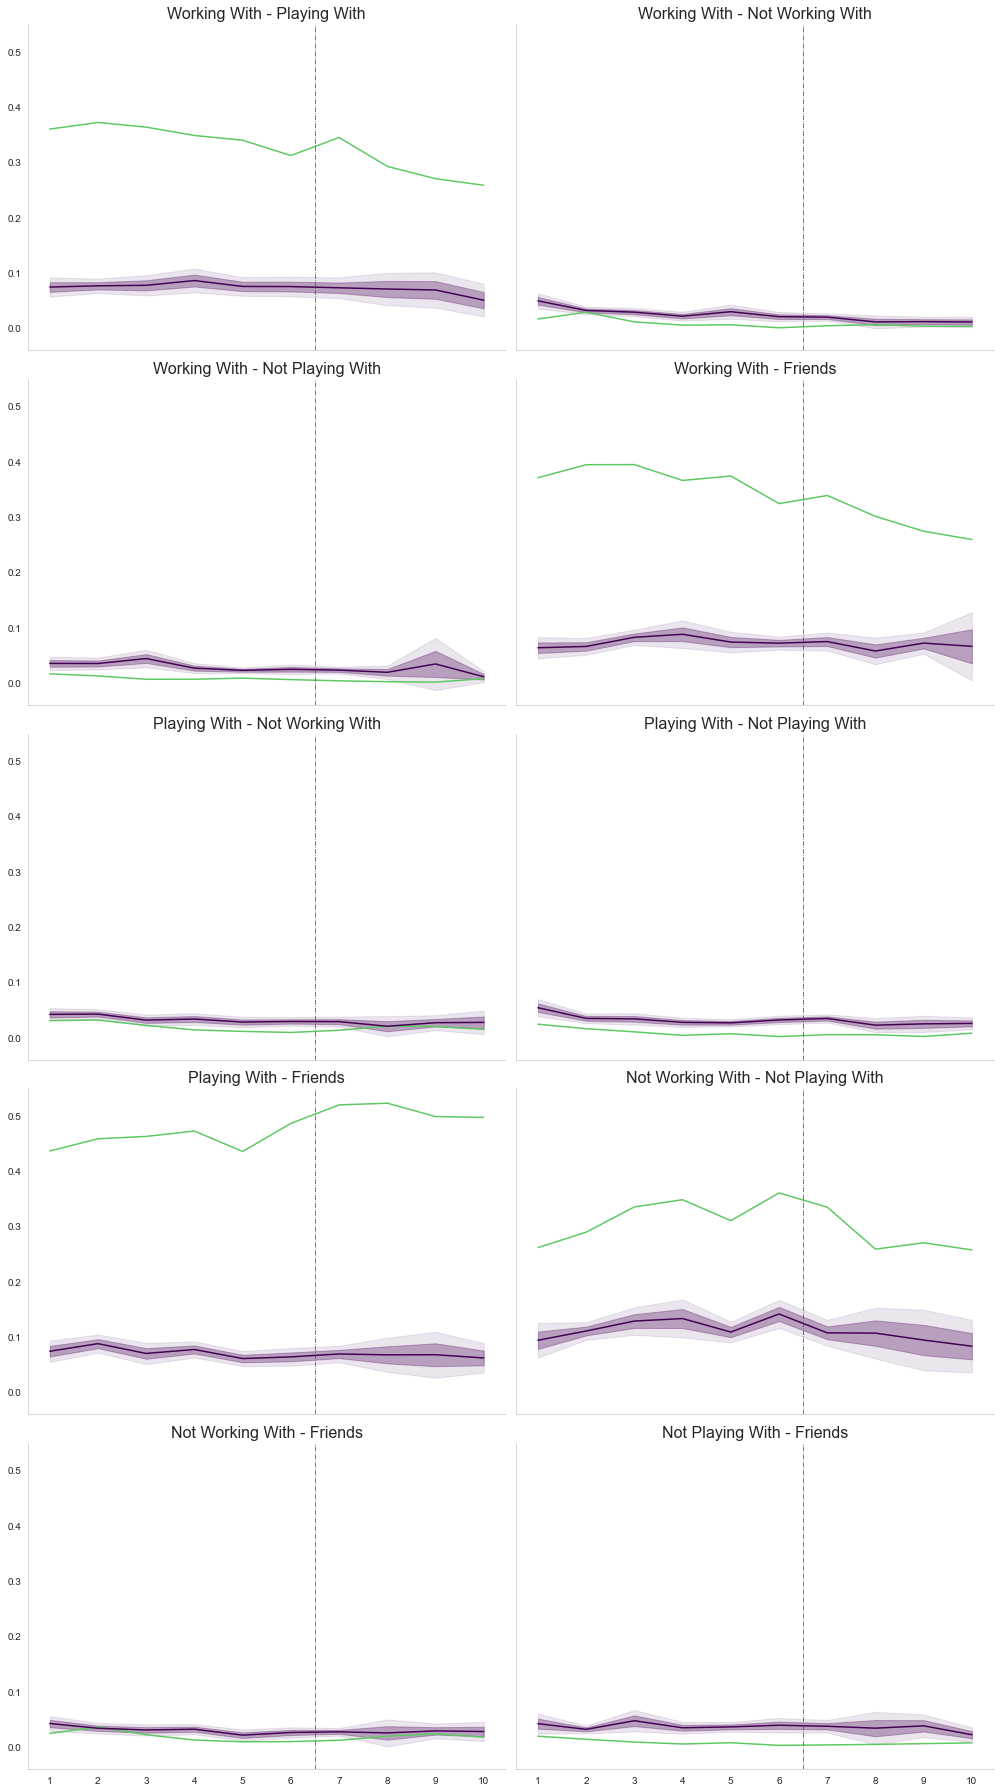

In [8]:
from itertools import combinations

# Generate all possible combinations of two different dimensions
dimension_pairs = list(combinations(["Working with", "Playing with", "Not working with", "Not playing with", "Friends"], 2))

# Number of rows needed for the subplot grid
num_rows = (len(dimension_pairs) + 1) // 2

# Create a main figure with subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(14, num_rows * 5), sharey=True, sharex=True) 
axes = axes.flatten() 

# Iterate over each pair and plot
for i, (dim1, dim2) in enumerate(dimension_pairs):
    data = compute_all(dim1, dim2)
    plot_name = f"{dim1} - {dim2}".replace("_", " ").title()
    cor_evo_plot_facet(data, ax=axes[i], plot_title=plot_name)

# Adjust layout for better fit and save the entire figure
plt.tight_layout()
fig.savefig("../plots/facet_plot_combinations.pdf", dpi=300, bbox_inches='tight')

In [9]:
from plot_vars import VERTICAL_LINE_COLOUR
import seaborn as sns
sns.set(font_scale=1.4, style="whitegrid")

def cor_evo_plot_interesting(cc, ax, lims=None, legend=False, y_labels=True):
    i = 0
    for name, a in cc.items():
        x, y, ci1 = structure_means(a, 1, type="sd")
        x, y, ci2 = structure_means(a, 2, type="sd")

        
        if name == "Null model":
            ax.plot(x, y, label=name, color=colours[i])
            ax.fill_between(x, (y - ci1), (y + ci1), color=colours[i], alpha=.3)
            ax.fill_between(x, (y - ci2), (y + ci2), color=colours[i], alpha=.1)
        else:
            ax.plot(x, y, label=name, color=colours[i])
        i += 1

    if legend:
        ax.legend(loc=(0.03, .31), prop={'size': 18}, frameon=False, fontsize=FONT_BIG)

    if not y_labels:
        ax.yaxis.set_ticklabels([])

    ax.xaxis.set_ticks(np.arange(1, 11, 1))
    ax.grid(False)
    ax.axvline(x=6.5, color=VERTICAL_LINE_COLOUR, linestyle='-.', linewidth=.75)

    if lims:
        ax.set_ylim(lims)

    ax.spines[['right', 'top']].set_visible(False)
    ax.tick_params(axis='both', which='major')


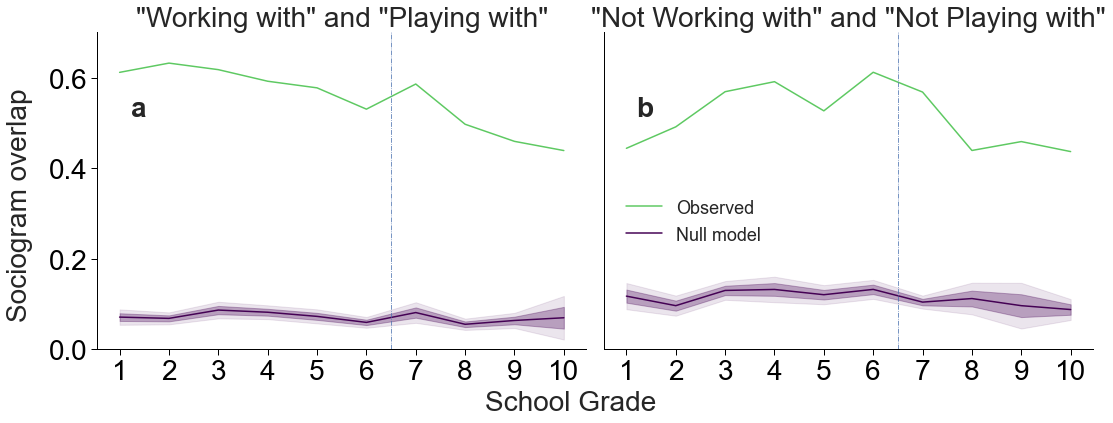

In [12]:
from plot_funcs import paint_it_black
from plot_vars import FONT_BIG
sns.set(font_scale=1.4, style="whitegrid")
# Create main figure with required number of subplots (e.g., 1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(15, 6))  

# First plot
data_1 = compute_all("Working with", "Playing with")
cor_evo_plot_interesting(data_1, axes[0], lims=[0, .7])
axes[0].set_title('"Working with" and "Playing with"', fontsize=FONT_BIG)

axes[0].text(0.1, 0.8, "a", 
             transform=axes[0].transAxes, 
             fontweight='bold', 
             va='top', 
             ha='right', 
             fontsize=FONT_BIG)

axes[0].tick_params(axis='x', which='both', bottom=True, labelbottom=True, labelsize=FONT_BIG)
axes[0].tick_params(axis='y', which='both', left=True, labelleft=True, labelsize=FONT_BIG)

# Second plot
data_2 = compute_all("Not working with", "Not playing with")
cor_evo_plot_interesting(data_2, axes[1], lims=[0, .7], legend=True, y_labels=False)
axes[1].set_title('"Not Working with" and "Not Playing with"', fontsize=FONT_BIG)
axes[1].text(0.1, 0.8, "b", 
             transform=axes[1].transAxes, 
             fontweight='bold', 
             va='top', 
             ha='right', 
             fontsize=FONT_BIG)

axes[1].tick_params(axis='x', which='both', bottom=True, labelbottom=True, labelsize=FONT_BIG)

paint_it_black(axes)

fig.text(0.5, 0.04, "School Grade", ha='center', va='center', fontsize=FONT_BIG)
fig.text(-0.01, 0.5, 'Sociogram overlap', ha='center', va='center', rotation='vertical', fontsize=FONT_BIG)
fig.tight_layout(rect=[0, 0.04, 1, 1])

# Optionally save the figure
fig.savefig("../plots/figure_3_interesting_correlations.pdf", dpi=300, bbox_inches='tight')


In [11]:
tt

,classroom,period,time,value,student,question,course
0,88,11,00:00:02.479,3737,3741,Not working with,7
1,88,11,00:00:02.680,3735,3741,Not working with,7
2,88,11,00:00:03.190,3741,3737,Friends,7
3,88,11,00:00:03.247,3746,3740,Playing with,7
4,88,11,00:00:03.288,3740,3743,Friends,7
...,...,...,...,...,...,...,...
1302151,247,11,00:00:57.644,6946,6933,Not working with,7
1302152,247,11,00:00:58.104,6935,6933,Not working with,7
1302153,247,11,00:01:02.147,6932,6930,Working with,7
1302154,247,11,00:01:16.523,6925,6937,Working with,7
